In [1]:
import os
from joblib import dump, load
from warnings import filterwarnings
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.ensemble import IsolationForest

from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from src.data_visuals import *
from src.feature_engineering import *
from src.utils import *

In [2]:
filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

plt.rcParams["font.size"] = 14.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [3]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)
data.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


# Data exploration

## [Variables](data/variables_info.txt)

All 28 variables in the dataset are continuous, except for "date", which has been set as the index.

The dataset contains:
* General appliances' energy usage (Appliances)
* Lights' energy usage (lights)
* Temperature and relative humidity in 8 rooms: kitchen, living room, office room, bathroom, two beedrooms, laundry room and ironing room, labeled as T1, Rh_1...T9, Rh_9 (excluding T6, RH_6 which represent temperature and humidity outside the house)
* Temperature and relative humidity outside the house (as mentioned above, and also from nearest weather station)
* Other weather data from the weather station (atmospheric pressure, windspeed, visibility, dew point).
* Two random variable (rv1, rv2) which can be used for testing

**Example variable distributions are depicted below**:
* T2 and RH_2 are temperature and humidity in the living room, while T5 and RH_5 - in the bathroom
* T_out, Press_mm_hg, Windspeed - data from nearest weather station
* rv1 - random variable

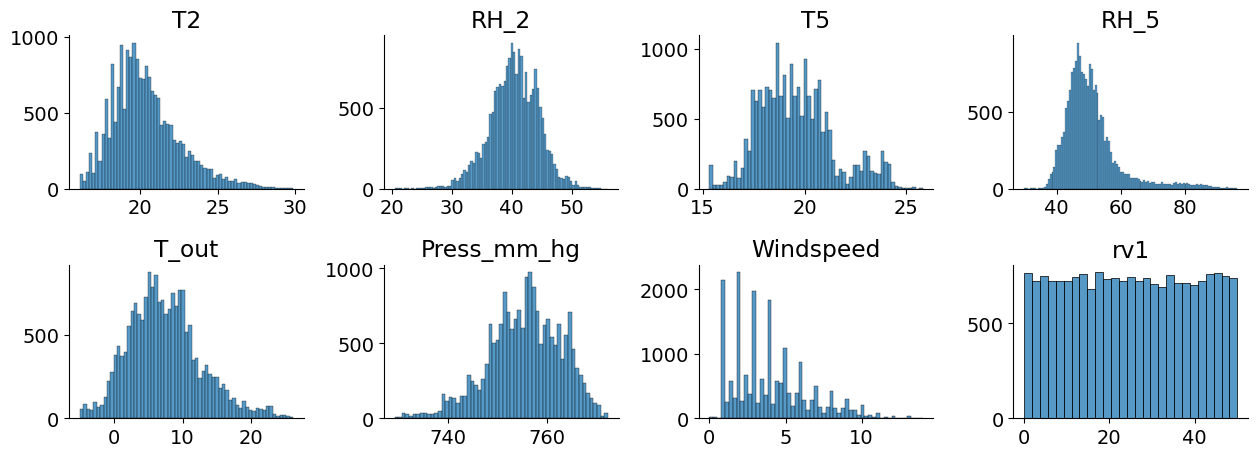

In [4]:
histplots_grid(2, 4, data, features = ["T2", "RH_2", "T5", "RH_5", "T_out", "Press_mm_hg", "Windspeed", "rv1"])

RH_6 contains information about the humidity outside the house, while RH_out provides data from the weather station. The distributions of these two variables can be seen below.

**The values in RH_6 are peculiar** and significantly differ from those obtained from the weather station, suggesting that a part of the measurement process might have gone wrong. For instance, there are many values at 0 and others less than 25%, which are improbable given the maritime temperate [climate of Belgium](https://en.wikipedia.org/wiki/Belgium#Geography) where such low humidity levels are virtually impossible. Moreover, it was mentioned [1] that the placement of the sensor for this parameter might not had been optimal. In contrast, the values in the RH_out variable appear more reasonable. Due to these discrepancies, **it was decided to exclude the RH_6 variable** and rely solely on the humidity information from RH_out.

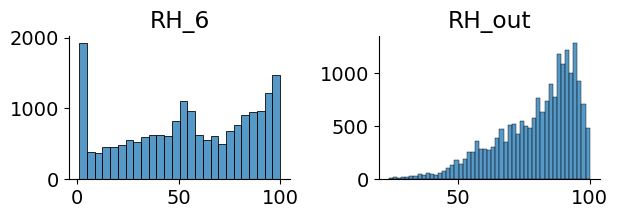

In [5]:
histplots_grid(1, 2, data, features = ["RH_6", "RH_out"])

The target variable might require a transformation due to its skewed distribution.

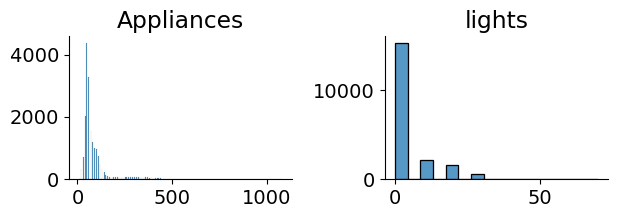

In [6]:
histplots_grid(1, 2, data, features = ["Appliances", "lights"])

In [110]:
# plt.figure(figsize=(20,20))
# sns.heatmap(data.corr(), annot=True, annot_kws={"fontsize":8})
# plt.show()

## Energy consumption over the entire time period covered by the data

It was verified that the time differences in the data are always equal to 10 minutes.

In [7]:
time_diffs = data.index.to_series().diff().dt.total_seconds().div(60)
time_diffs.min(), time_diffs.max()

(10.0, 10.0)

In **the heatmap below**, one can see an overall view of the daily average energy consumption by devices over the entire period represented by the data. It's difficult to discern any trends by looking at individual days, but it seems that in subsequent months there are more days with low consumption. It can be hypothesized that as the weather warms up over the year, residents may spend less time at home. This is also slightly visible in the daily consumption by month, but it is not very pronounced - this is also influenced by **unusual periods of minimal consumption**, for example, January 27-29.

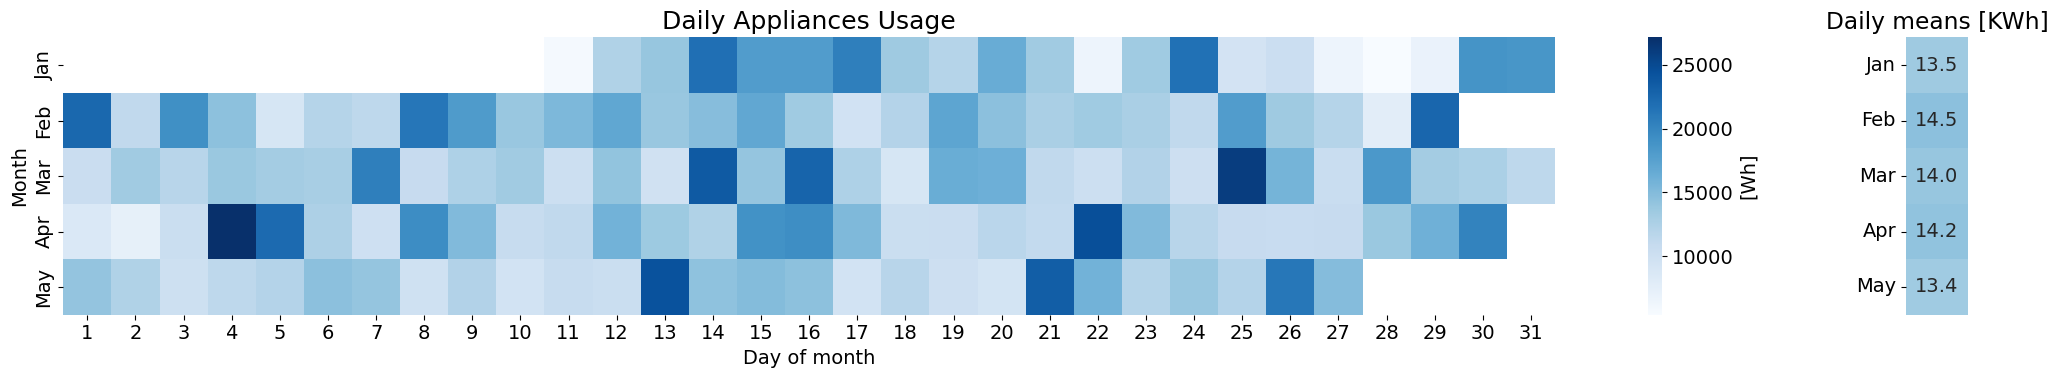

In [4]:
energy_consumption_all_time(data.Appliances)

In **the chart below**, it can be seen that light usage decreases over time, especially from around the end of March. This is associated with the days getting longer at the Belgium's latitude. Additionally, in Belgium, there is a time change at the end of March to save energy.\
It's noteworthy that the data does not reflect the clock change (a 1-hour advancement on the last Sunday of March); therefore, it is likely that a consistent time standard is used throughout the entire period covered by the data.

Another point to observe is that there are two periods (each 2-3 days long, **mentioned above as unusual**) where there is no light energy consumption and general consumption is minimal. It is assumed that during these days, the usual daily activities did not occur - probably because nobody was home.

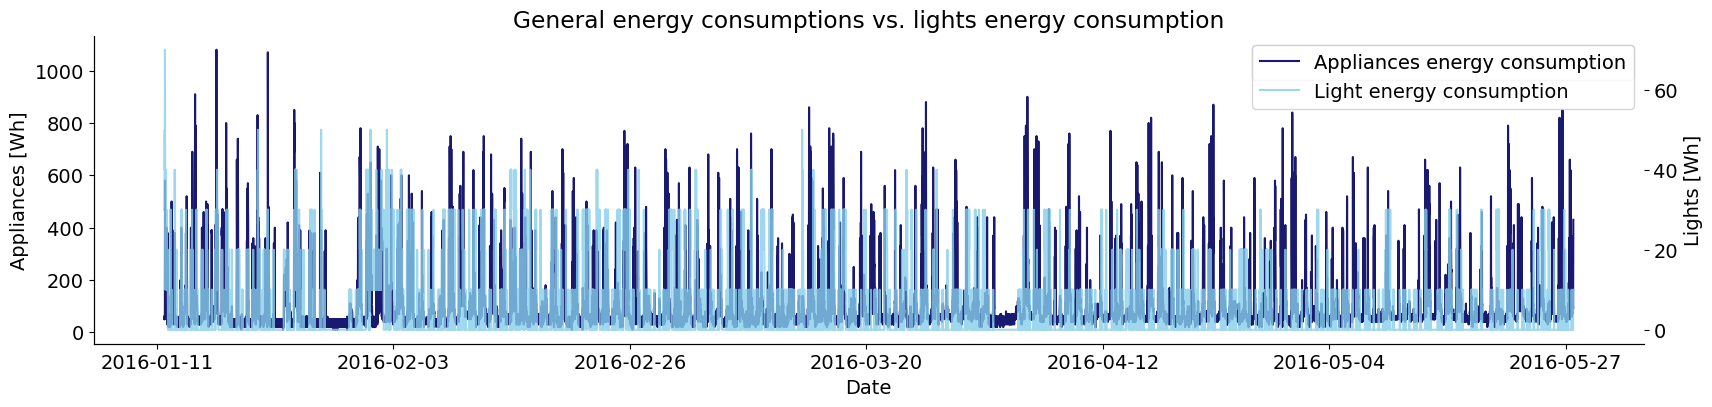

In [5]:
energy_vs_lights_plot(data.Appliances, data.lights)

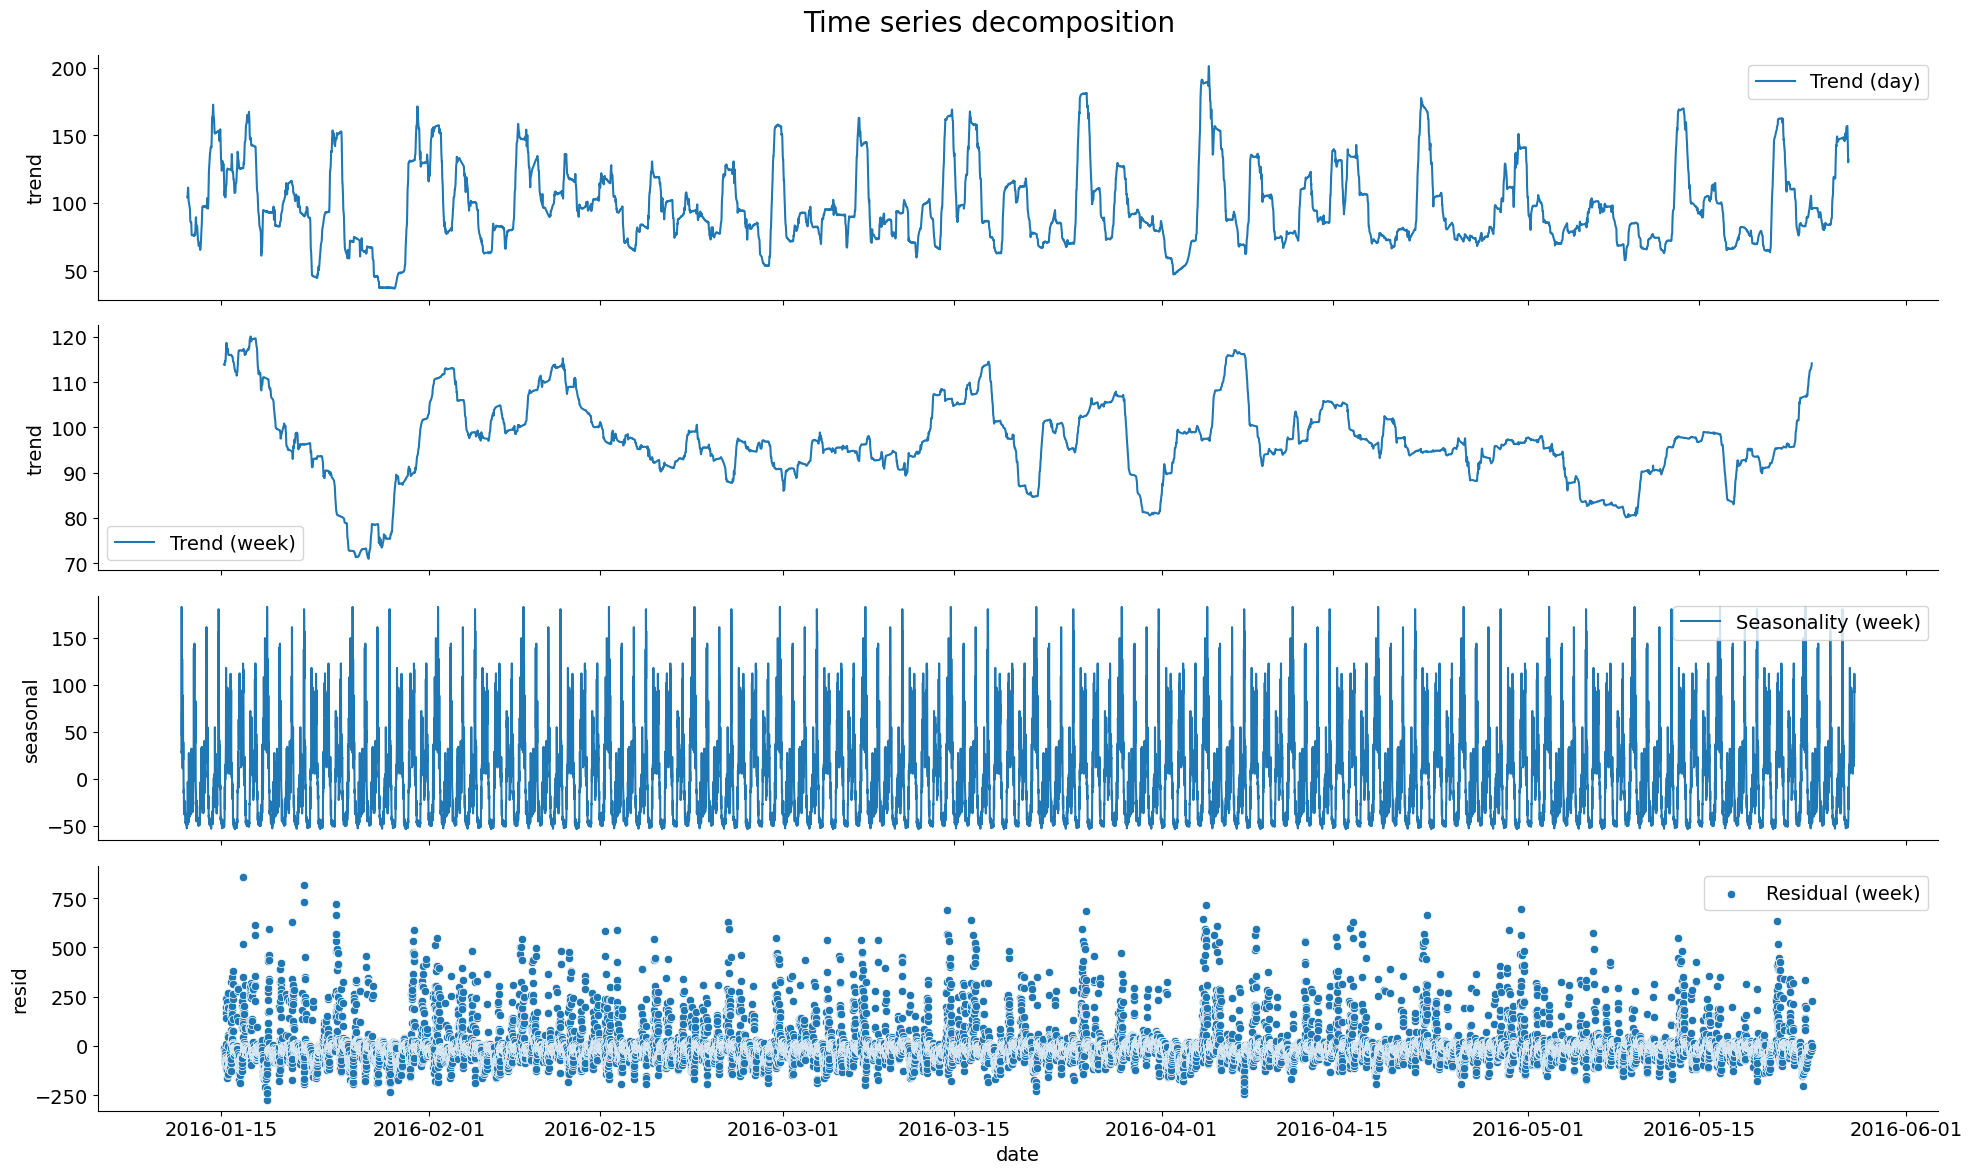

In [6]:
result_by_day = sm.tsa.seasonal_decompose(data.Appliances, model="additive", period=144)
result_by_week = sm.tsa.seasonal_decompose(data.Appliances, model="additive", period=1008)

time_series_decomposition(result_by_day, result_by_week)

Time series autocorrelation and partial autocorrelation

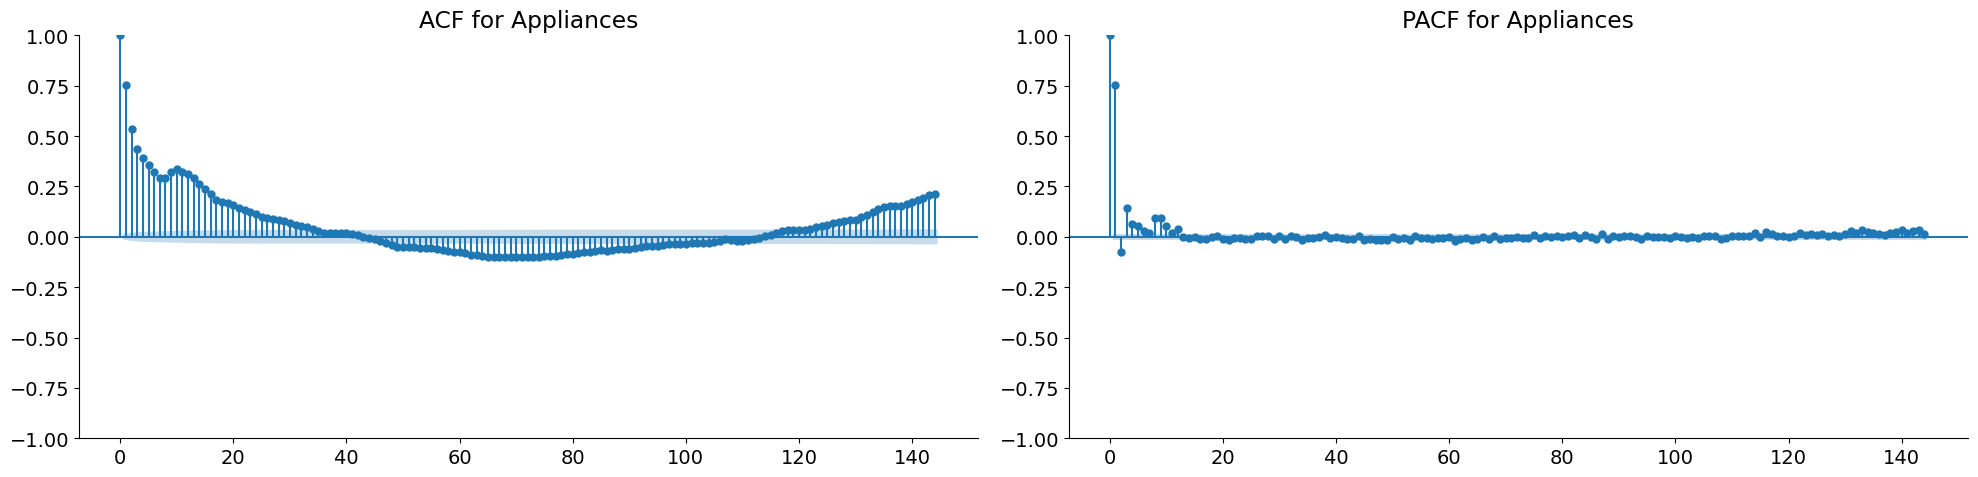

In [7]:
acf_pacf(data.Appliances, 144)

## Energy consumption in smaller periods

At this stage, certain datetime features were added that can be helpful for further analysis.

In [5]:
enhancer = DataEnhancer(data)
enhanced_data = enhancer.add_datetime_features().data

enhanced_data.iloc[:,-8:].head(3)

,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend
date,,,,,,,,
2016-01-11 17:00:00,Monday,17,0,evening,2,11,0,0
2016-01-11 17:10:00,Monday,17,10,evening,2,11,0,0
2016-01-11 17:20:00,Monday,17,20,evening,2,11,0,0


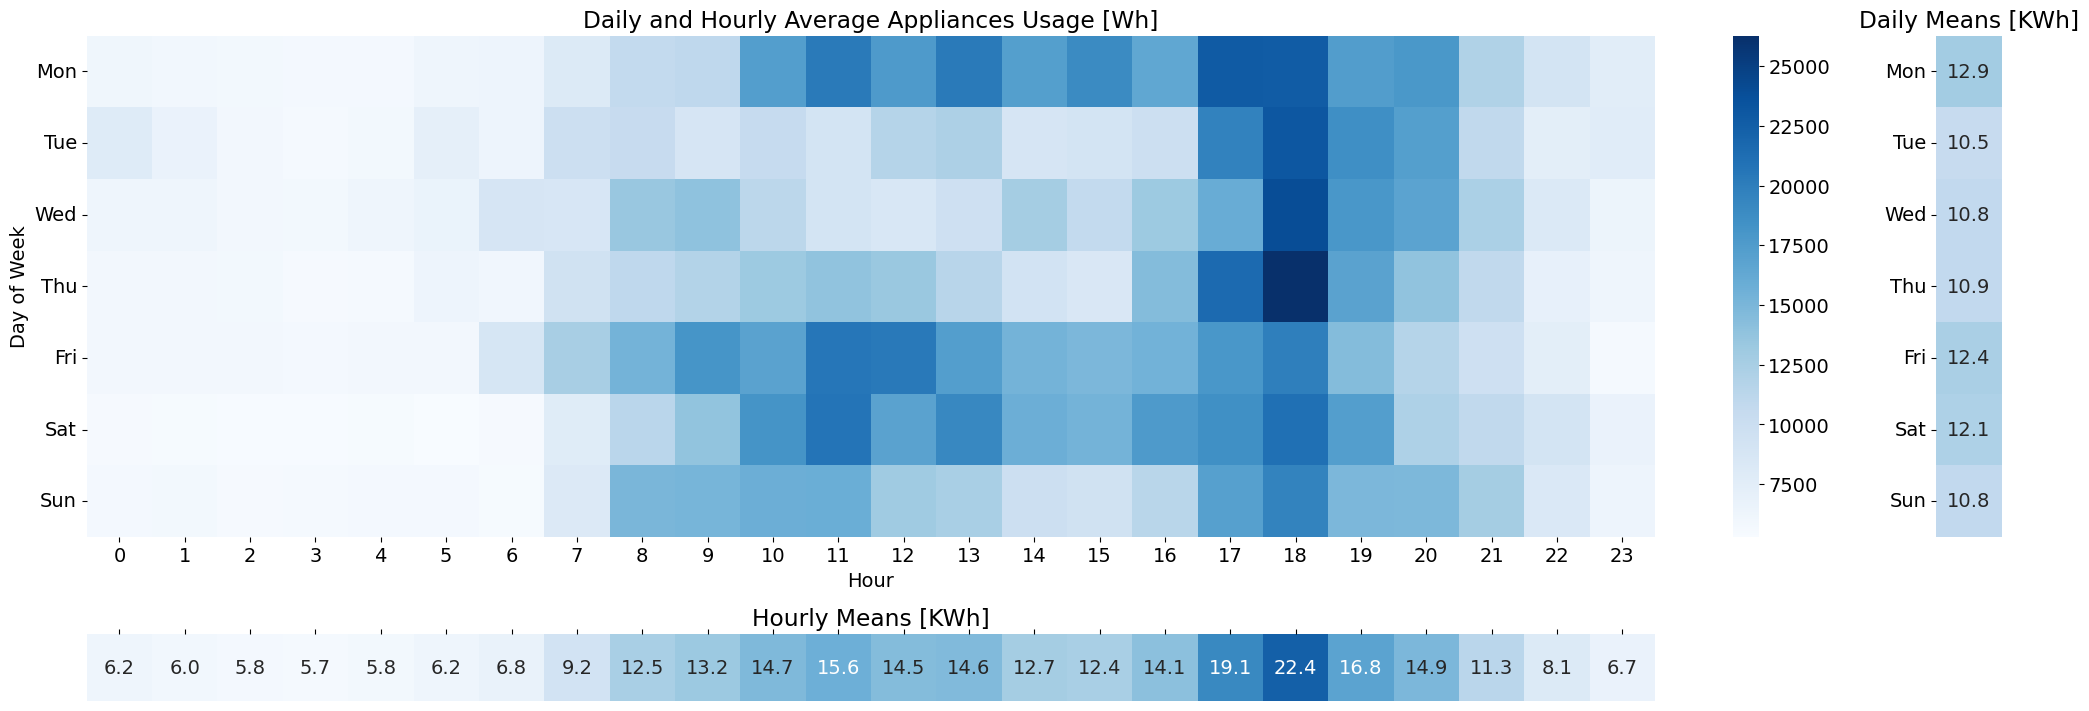

In [6]:
consumption_by_day_and_hour(enhanced_data[["Appliances", "day_of_week", "hour"]])

### Exploring data by weeks

In [10]:
visualizer = WeeklyDataVisualizer(enhanced_data)

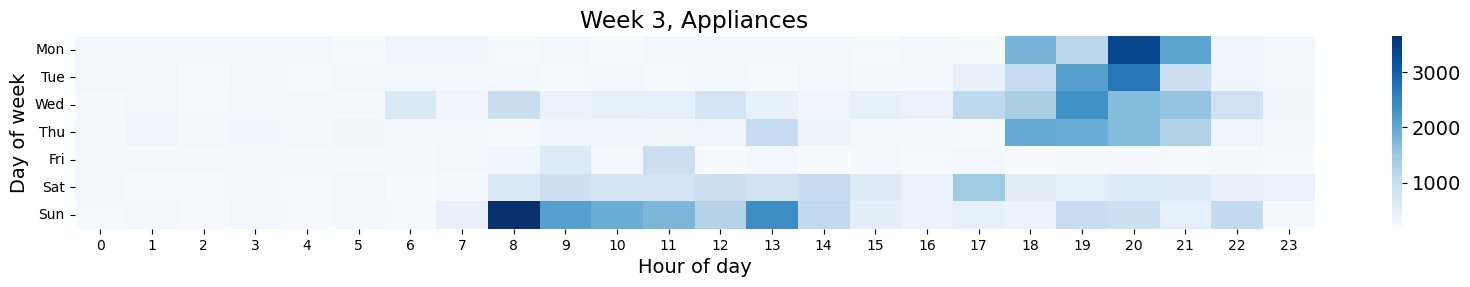

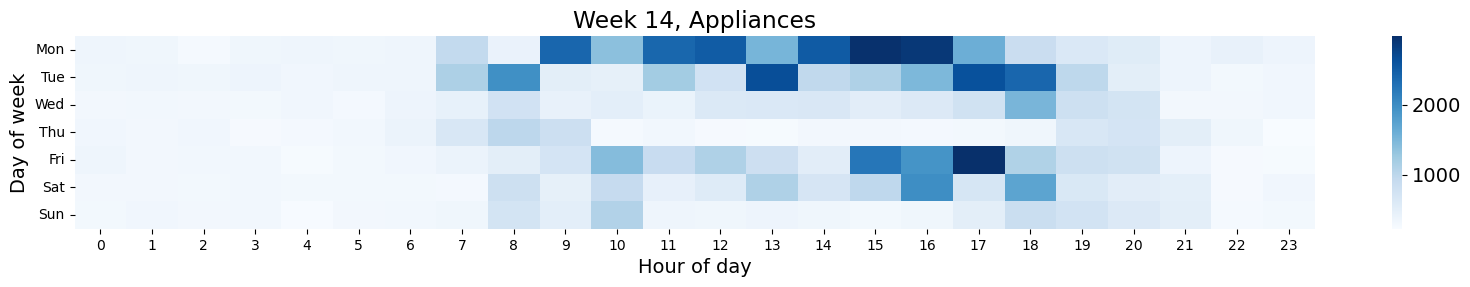

In [11]:
visualizer.plot_heatmap([3, 14], "Appliances")

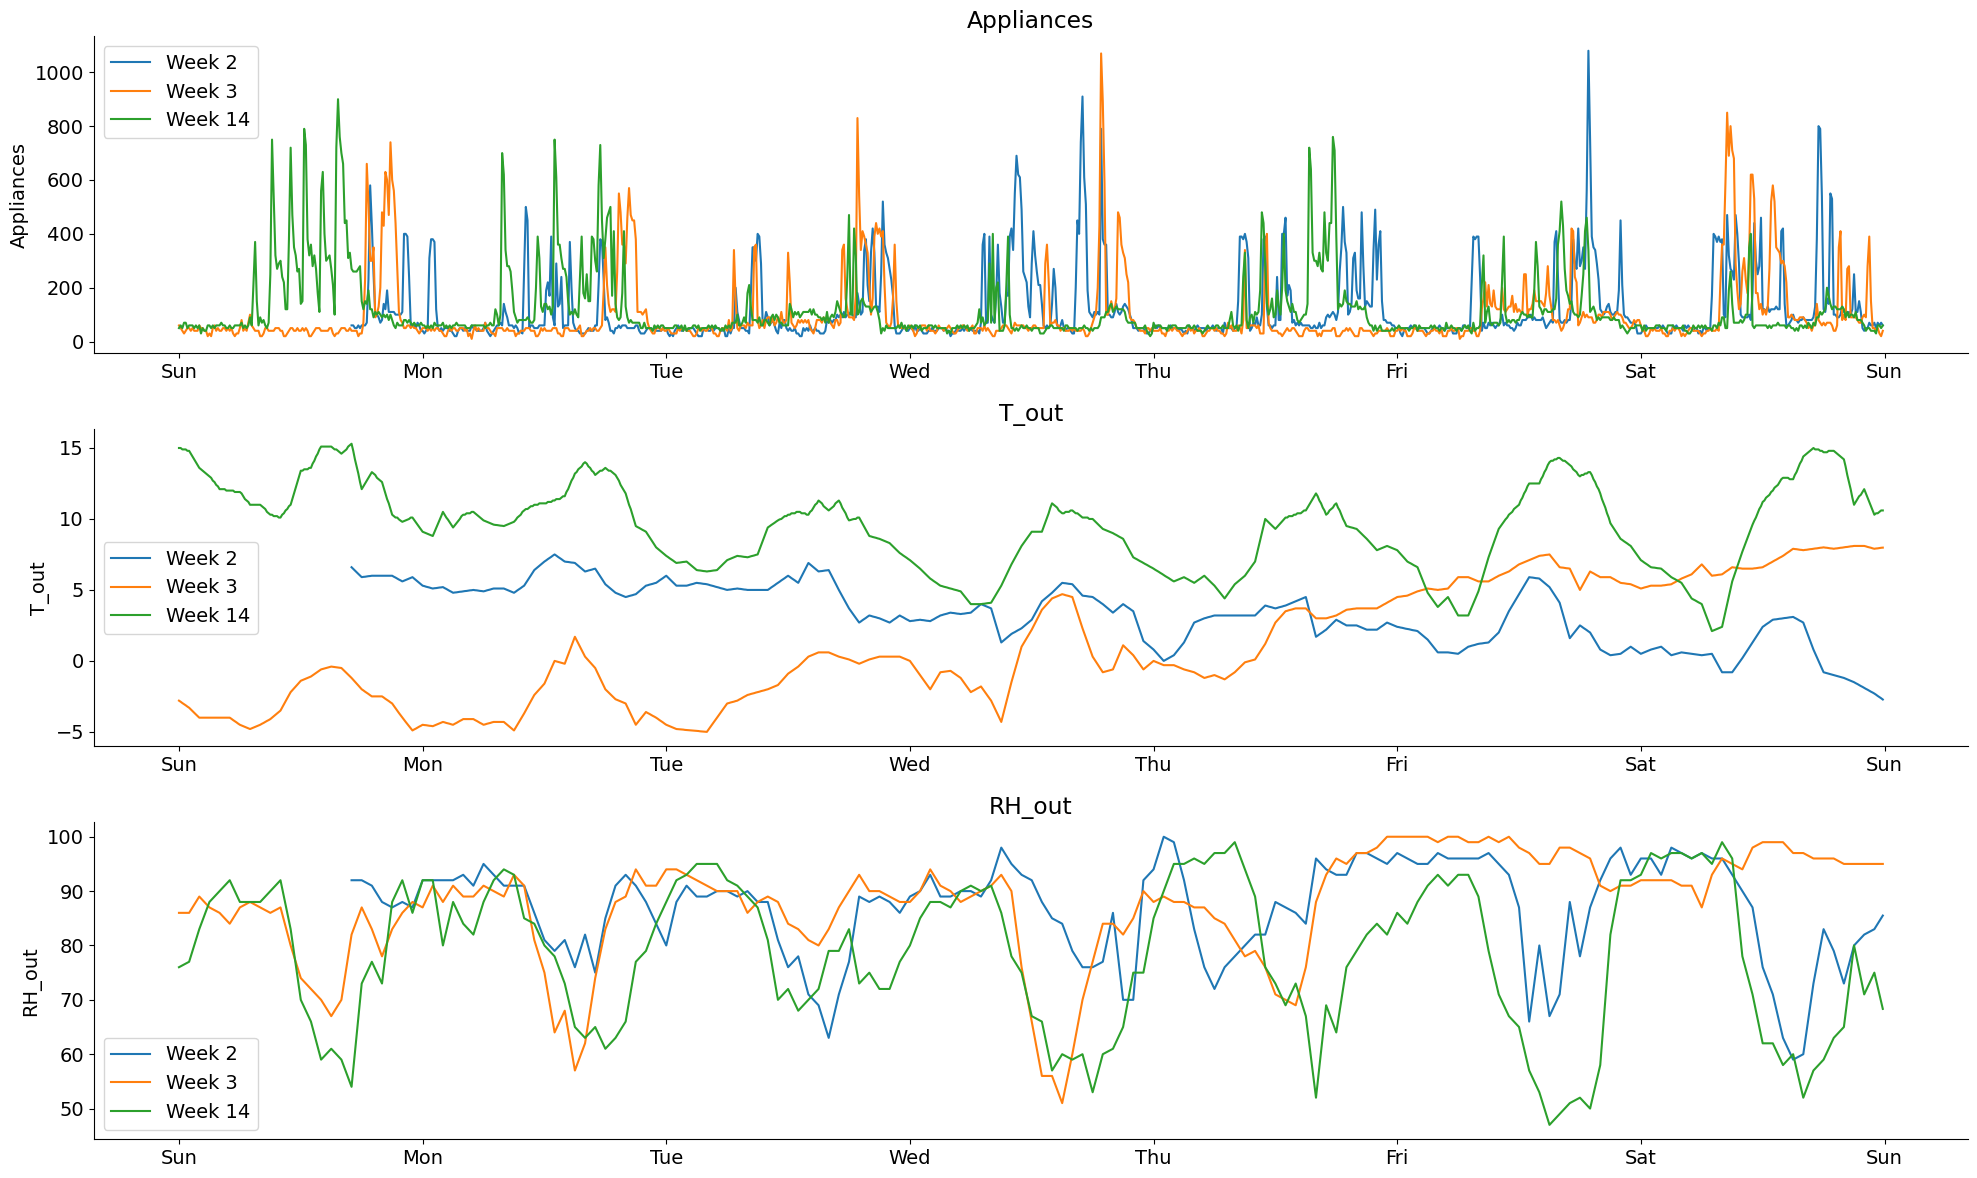

In [22]:
visualizer.plot_many_weeks(weeks=[2, 3, 14], columns=["Appliances", "T_out", "RH_out"])

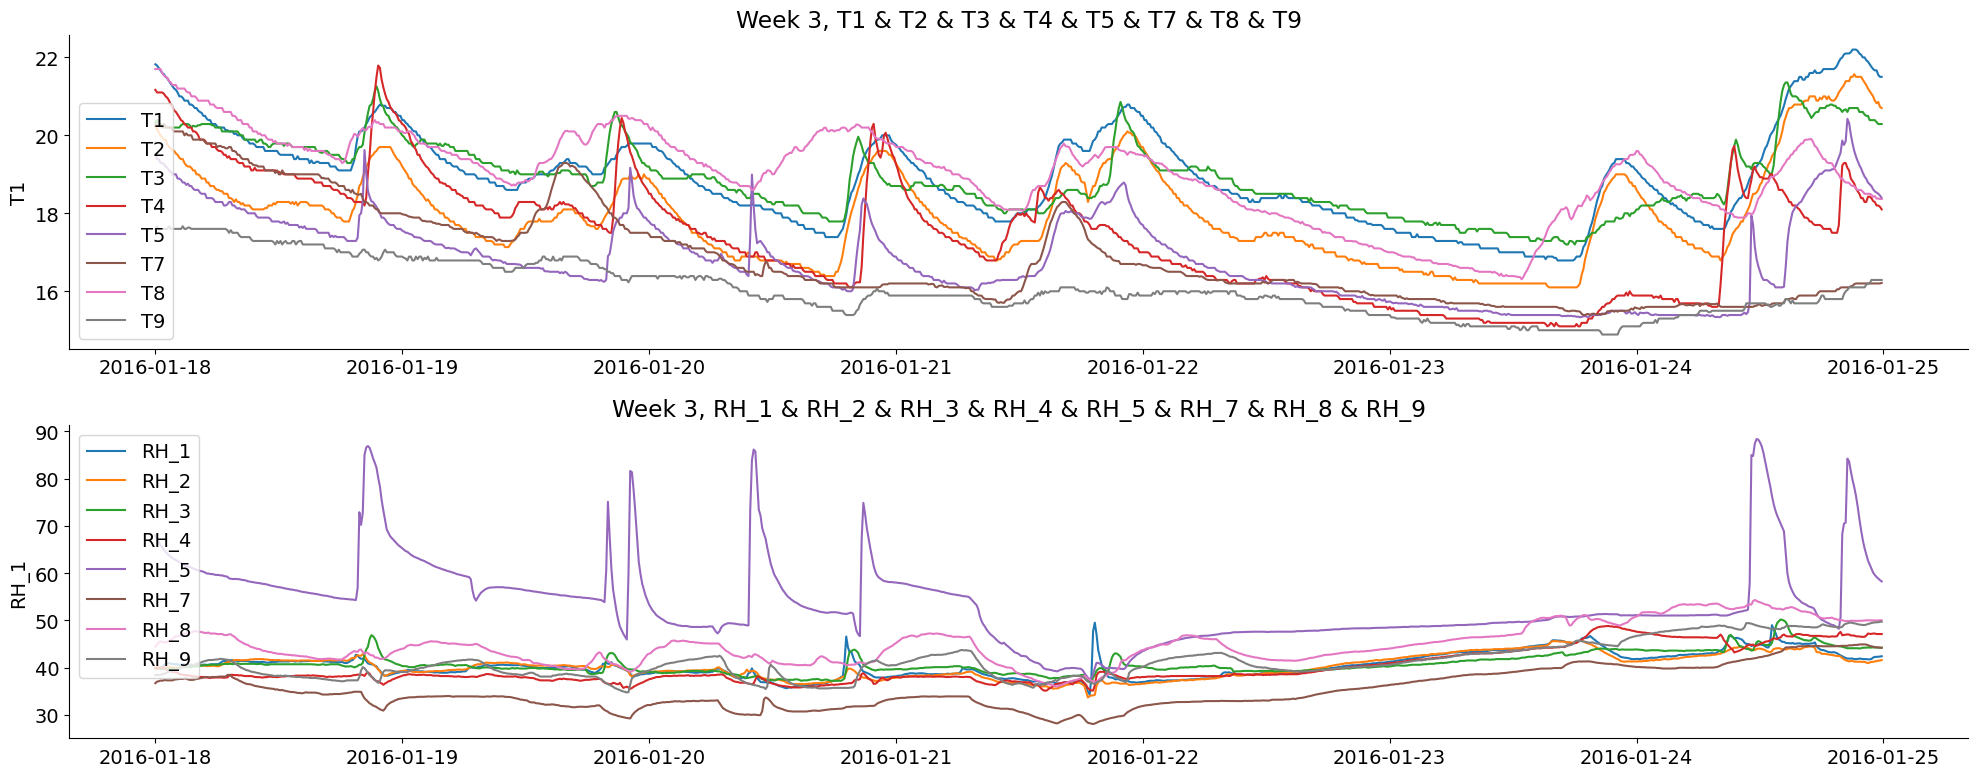

In [12]:
visualizer.plot_one_week(3, columns=[["T1", "T2", "T3", "T4", "T5", "T7", "T8", "T9"],
                                     ["RH_1", "RH_2", "RH_3", "RH_4", "RH_5", "RH_7", "RH_8", "RH_9"]])

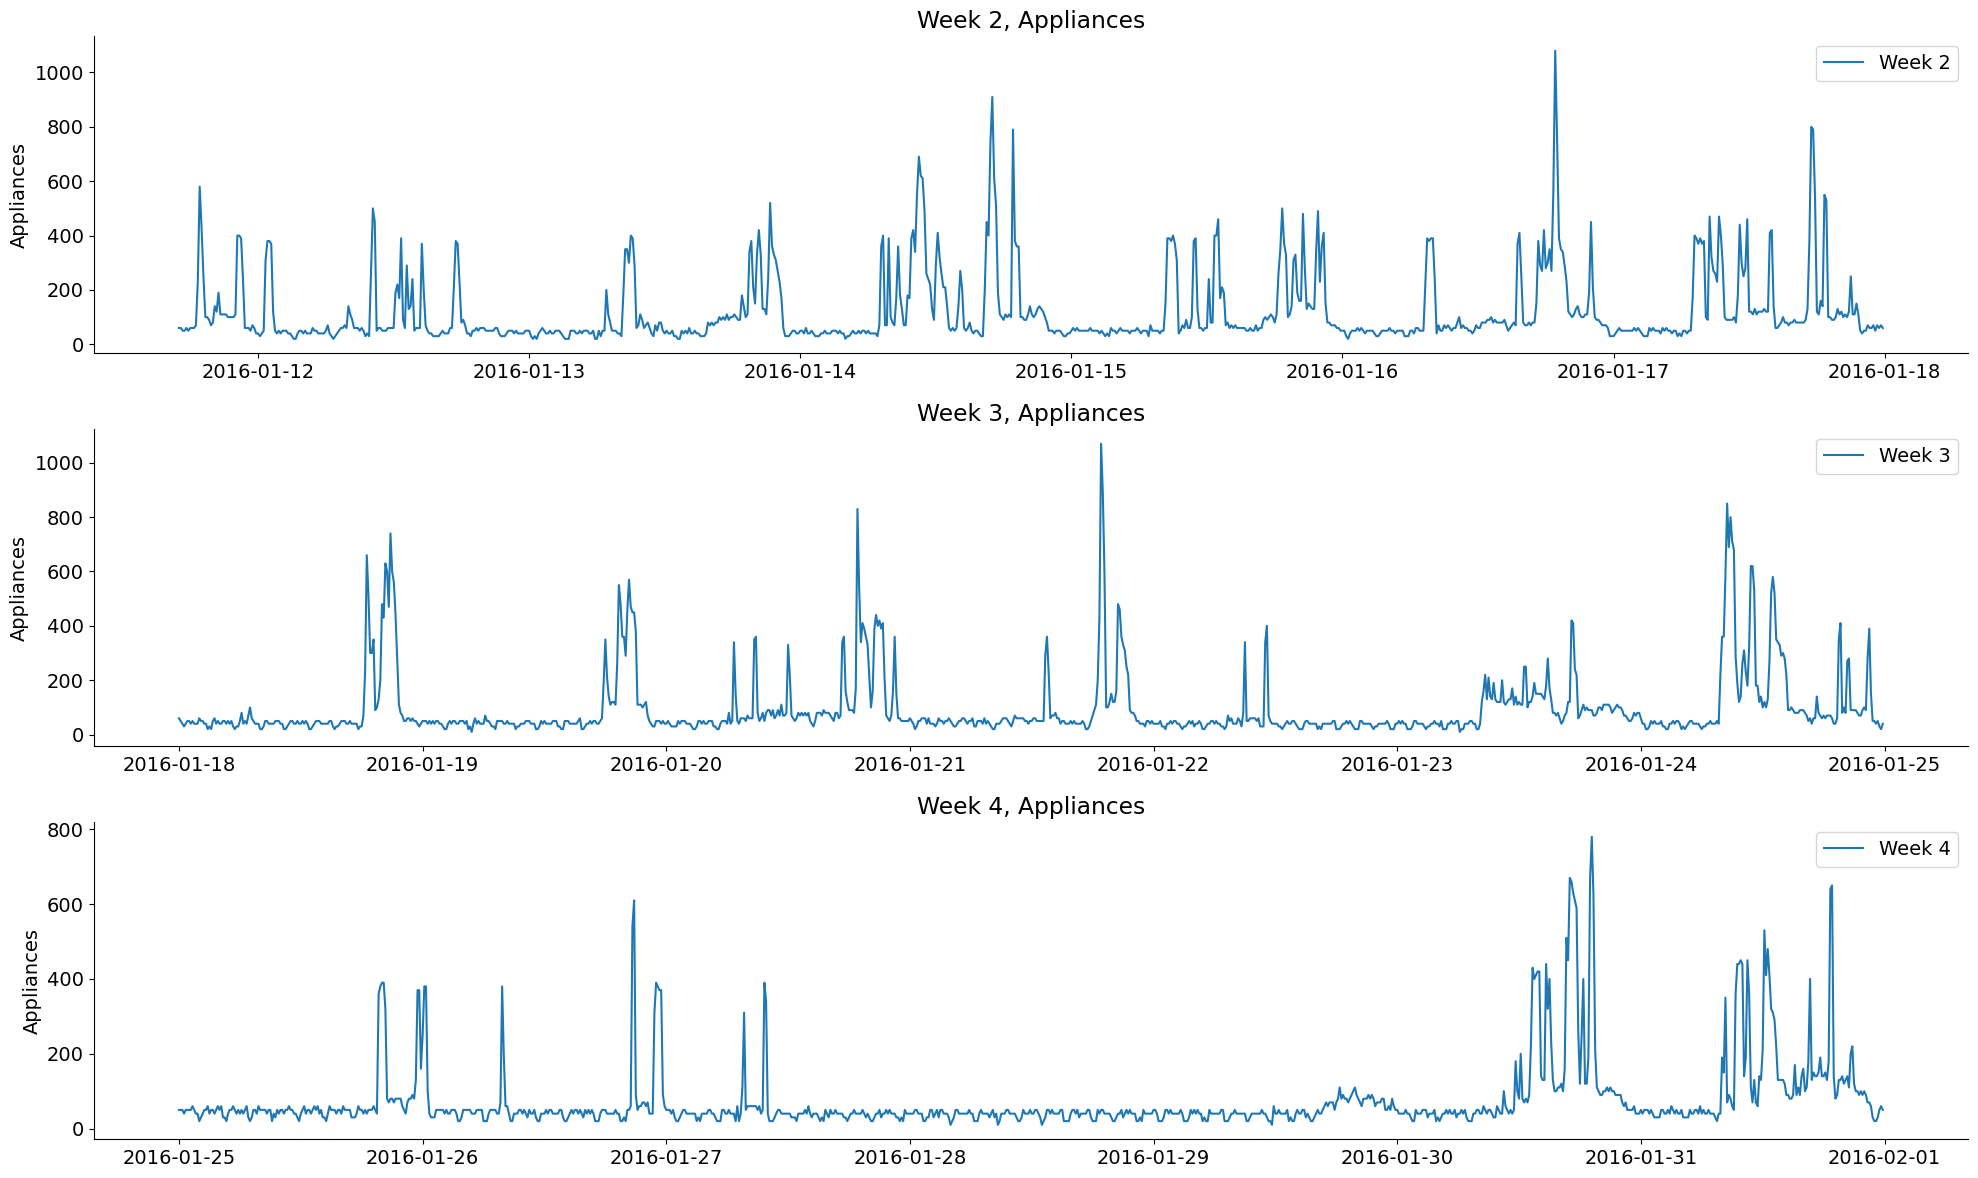

In [13]:
visualizer.plot_many_weeks(weeks=[2, 3, 4], columns=["Appliances"], single_plot=False)